In [77]:
!python -m pip install librosa
!pip install pydub

In [78]:
!ls

angry_speech.wav      speech_analysis.ipynb


In [79]:
from pydub import AudioSegment
from pydub.utils import mediainfo
import scipy
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from IPython import display
import IPython.display as ipd

## Read speech file and perform analysis
---

In [80]:
# Get audio info

wavfile = "./angry_speech.wav"
info = mediainfo(wavfile)
duration = float(info['duration']) # in seconds

msg = f"""  file name          : {info['filename']}
      file size          : {float(info['size'])/1024} kb
      audio duration     : {info['duration']} Sec
      sample rate        : {info['sample_rate']} 
      no: audio channels : {info['channels']}"""
print(msg)

  file name          : ./angry_speech.wav
      file size          : 142.54296875 kb
      audio duration     : 4.560000 Sec
      sample rate        : 16000 
      no: audio channels : 1


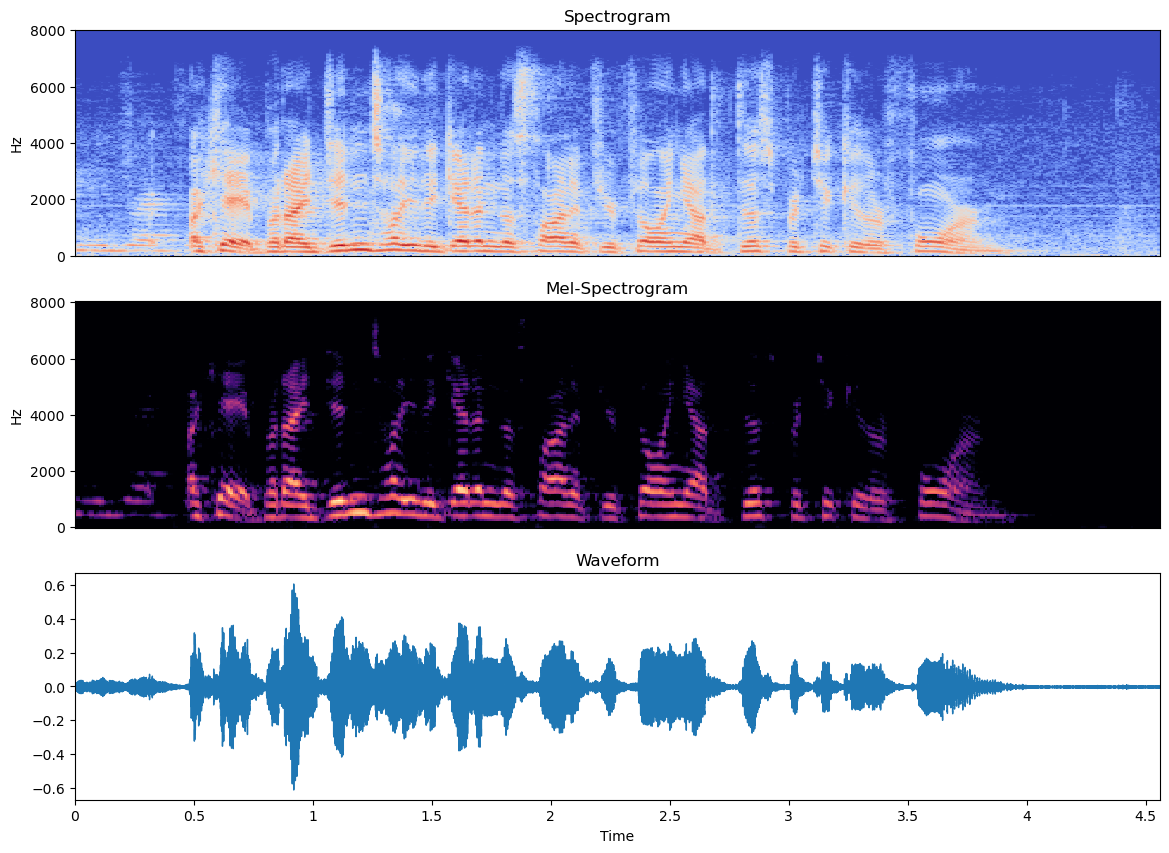

In [81]:
# Load audio file and compute spectrograms

waveform, srate = librosa.load(wavfile, sr=librosa.get_samplerate(wavfile))
n_samples = len(waveform)
frm_size = int(0.032 * srate)       # 32ms per frame
frm_shift = int(0.01 * srate)       # 100Hz frame rate
n_fft = n_samples if (n_samples < frm_size) else frm_size

# Compute magnitude spectrogram
complex_spec = librosa.stft(y=waveform, n_fft=frm_size, hop_length=frm_shift)
magspec = abs(complex_spec)

# Compute mel-spectrogram
melspec = librosa.feature.melspectrogram(y=waveform, sr=srate, n_fft=n_fft, 
                                         hop_length=frm_shift, center=False)

# Plot spectrograms and waveform
plt.figure(figsize=(14, 10))
plt.subplot(311)
plt.title('Spectrogram')
librosa.display.specshow(librosa.amplitude_to_db(magspec), sr=srate, y_axis='linear', 
                         hop_length=160)
plt.subplot(312)
plt.title('Mel-Spectrogram')
librosa.display.specshow(librosa.amplitude_to_db(melspec), sr=srate, y_axis='linear', 
                         hop_length=160)
plt.subplot(313)
plt.title('Waveform')
librosa.display.waveshow(waveform, sr=srate, offset=0)

plt.margins(x=0)
plt.show()

In [82]:
# Playback the audio file
ipd.Audio(waveform, rate=srate) 

In [83]:
# normalizing 
samples = waveform/waveform.max()

# Create x-axis timeline
timeline = np.linspace(0, duration, len(samples))

## Energy-based Voice Activity Detection

In [84]:
# Initializing variables

weight = 0.1 # weight or a adjustable parameter
v_window = int(0.01*len(samples)) # window size = here we take 1% of sample size.
vad_T = np.mean(samples**2) * weight
vad_T, v_window

(0.0012617317959666254, 729)

In [85]:
# Voice activity detection

vad = np.zeros(shape=samples.shape)
ref_idx = []
for s_set in range(0, len(waveform)-v_window, v_window):
      win_samples = waveform[s_set:(s_set + v_window)]
      s_T = np.mean(win_samples**2)
      if s_T > vad_T:
        vad[s_set:(s_set + v_window)] = 1.0
        ref_idx.append(s_set)
      else:
        vad[s_set:(s_set + v_window)] = 0.0

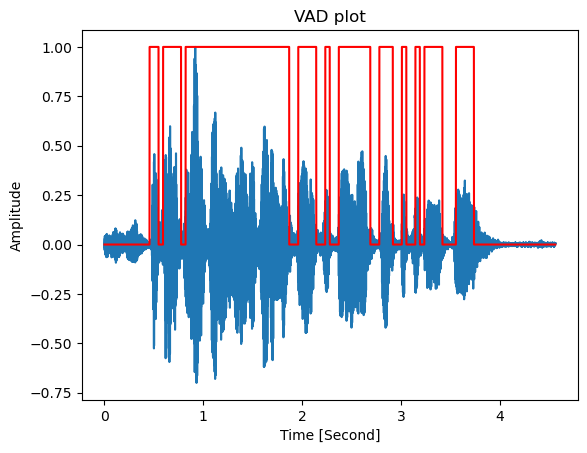

In [86]:
# Plotting audio samples and VAD decisions
plt.plot(timeline, samples)
plt.plot(timeline, vad, color='red')
plt.title("VAD plot")
plt.xlabel("Time [Second]")
plt.ylabel("Amplitude")
plt.show()

## Pre-emphasis

In [87]:
# pre-emphasising audio signal

alpha = 0.97
emphasized_signal = np.append(samples[0], samples[1:] - alpha * samples[:-1])
emphasized_signal.shape

(72960,)

In [89]:
# Compare the original and the pre-emphasized signals
ipd.Audio(emphasized_signal, rate=srate) 

In [90]:
ipd.Audio(waveform, rate=srate) 